<a href="https://colab.research.google.com/github/HermitCrab07/Designing_Responsible_Ethical_AI/blob/main/Evaluation_BC_Tool_BASIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --quiet openai pandas tqdm

In [ ]:
import os, json, pandas as pd
from tqdm import tqdm
import openai

openai.api_key = "YOUR OPEN API KEY"
MODEL = "gpt-4o"   # using gpt-4o model

import os

In [ ]:
os.environ["OPENAI_API_KEY"] = "YOUR OPEN API KEY"

In [ ]:
df = pd.read_csv("/content/BC_Cases_OncoAI.csv")

# Drop columns that start with 'Unnamed'
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]

display(df.columns)
display(df)

Index(['case_id', 'CaseDetails', 'OncoAI'], dtype='object')

In [ ]:
'''
# 6. Simple Rubric_text previously defined but more comprehensive rubric defined below. See the details in next cell. Might return to this because it is simple.

SIMPLE_RUBRIC_TEXT = """
Score this breast‑cancer treatment guideline on each criterion (0=poor, 1=partial, 2=good):

1. Diagnosis & Subtype correctness
2. Treatment sequence appropriateness
3. Pre-treatment work‑up completeness
4. Chemo specificity & dosing accuracy
5. Targeted / Endocrine / Immunotherapy correctness
6. Surgery plan appropriateness
7. Radiation plan appropriateness
8. Supportive care & monitoring
9. Follow‑up & survivorship plan
10. Guideline citation / alignment

Return ONLY valid JSON like:
{
  "criterion_1": 2,
  "criterion_2": 1,
  ...
  "criterion_10": 0,
  "total": 12
}
"""
'''

In [2]:
# 7. Score_Guideline function - sets [1] Rubric [2] Penalty [3] Scoring [4] JSON output [5] Model [6] Temperature

def score_guideline(case_id, case_description, treatment_guideline_onco):
    system_instructions = (
        "You are a strict medical evaluator comparing a proposed breast cancer treatment plan "
        "against current clinical guidelines (e.g., NCCN 2024, ASCO 2024, KEYNOTE-522). "
        "Your goal is to evaluate 10 rubric items, assign a score (0, 1, or 2), and give clear justifications. "
        "You must determine whether each error is critical or minor and apply **explicit penalty rules** "
        "based on the table below."
    )

    user_prompt_content = f"""
**Rubric & Penalty Weights (out of 2 points per category):**

1. Diagnosis & Subtype
   - Correct TNBC classification and HER2-equivocal handling: 2 pts
   - Minor labeling error (e.g. missing HER2-equivocal mention): 1 pt
   - Incorrect subtype classification: 0 pts

2. Treatment Sequence
   - Fully guideline-aligned (NAC first, fertility, surgery, RT): 2 pts
   - Missing fertility or minor step: 1 pt
   - Out-of-order or omits key phase (e.g., skips NAC): 0 pts

3. Pre-Treatment Work-Up
   - Includes imaging, cardiac echo, genetics, pregnancy test: 2 pts
   - Missing 1–2 elements: 1 pt
   - Omits major categories: 0 pts

4. Systemic Therapy
   - TNBC regimen with paclitaxel, dose-dense AC, ± carboplatin, pembrolizumab: 2 pts
   - Missing pembro or uses trastuzumab without HER2+: 1 pt (critical error)
   - Wrong drugs entirely or missing NAC: 0 pts

5. Surgery Plan
   - BCS vs mastectomy post-NAC, SLNB logic clear: 2 pts
   - Surgery type unclear or lymph logic weak: 1 pt
   - Incorrect surgery timing or staging: 0 pts

6. Radiation Plan
   - RT to breast post-BCS only; no axillary RT if node-neg: 2 pts
   - Adds unnecessary axillary RT: 1 pt (minor error)
   - Omits RT entirely or misapplies dose: 0 pts

7. Targeted / Immunotherapy
   - Trastuzumab only if HER2+ confirmed; pembro included if eligible: 2 pts
   - Mentions but doesn’t include in plan: 1 pt
   - Uses trastuzumab without HER2+ or misses both: 0 pts (critical)

8. Supportive Care & Monitoring
   - G-CSF, antiemetics, echo, fertility referral: 2 pts
   - Missing 1–2 components: 1 pt
   - Omits all supportive care: 0 pts

9. Follow-Up & Survivorship
   - Surveillance, imaging, toxicity management: 2 pts
   - Missing one element: 1 pt
   - Omits survivorship or toxicity entirely: 0 pts

10. References
   - NCCN, CALGB, KEYNOTE, ASCO guidelines cited: 2 pts
   - Missing or vague references: 1 pt
   - No references: 0 pts

For each rubric item, give:
• The score (0/1/2)
• Whether the issue is a critical or minor error
• A 1-sentence rationale
Then return a final total score out of 20.

Critcal errors (score 0) are those that could lead to significant harm or incorrect treatment decisions, such as misidentifying the cancer stage, recommending an inappropriate primary treatment modality (e.g., surgery instead of chemotherapy for a stage IV case where surgery is not indicated), or incorrect dosing of critical medications.
Minor errors (score 1) are less severe and may include minor inaccuracies in supportive care recommendations, less optimal but still acceptable sequencing of treatments, or minor omissions in follow-up plans that do not immediately endanger the patient. A score of 2 indicates the guideline is good and aligns well with the reference or best practices.

PATIENT CASE
------------
{case_description}

PROPOSED GUIDELINE
------------------
{treatment_guideline_onco}

JSON:"""

    # Setting temperature to a low value (e.g., 0.1) for more consistent output
    # Defining penalty weights explicitly
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_instructions},
            {"role": "user", "content": user_prompt_content}
        ],
        temperature=0.1, # Low temperature for consistency
        max_tokens=300,
        response_format={ "type": "json_object" },
        # Explicitly defining penalty weights (example values, adjust as needed)
        presence_penalty=0.0, # No penalty for new tokens
        frequency_penalty=0.0 # No penalty for frequently appearing tokens
    )
    raw = response.choices[0].message.content

    try:
        scores = json.loads(raw)
    except json.JSONDecodeError:
        print(f"⚠️  {case_id}: JSON parse error. Raw output below.\n{raw}\n")
        scores = {}
    return scores

In [ ]:
all_scores = {}
for _, row in tqdm(df.iterrows(), total=len(df)):
    sc = score_guideline(row.case_id, row.CaseDetails, row.OncoAI)
    all_scores[row.case_id] = sc


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


In [ ]:
# Take evaluation results in a dictionary and integrate them back into the DataFrame
# add each criterion as a new column
for cid in range(1, 11):
    col = f"criterion_{cid}"
    df[col] = df.case_id.map(lambda x: all_scores.get(x, {}).get(col))

df["total_score"] = df.case_id.map(lambda x: all_scores.get(x, {}).get("total"))

df.to_csv("cases_scored.csv", index=False)
print("✅  Saved cases_scored.csv")


✅  Saved cases_scored.csv


In [ ]:
scored_df = pd.read_csv("cases_scored.csv")

# Drop columns that start with 'Unnamed'
scored_df = scored_df.loc[:, ~scored_df.columns.str.startswith('Unnamed')]

print(scored_df.columns)

Index(['case_id', 'CaseDetails', 'OncoAI', 'criterion_1', 'criterion_2',
       'criterion_3', 'criterion_4', 'criterion_5', 'criterion_6',
       'criterion_7', 'criterion_8', 'criterion_9', 'criterion_10',
       'total_score'],
      dtype='object')


# Task
Generate OpenAI treatment recommendations based on case details, compare them to existing OncoAI guidelines using a 10-point rubric scored 0, 1, or 2, store the evaluation scores, analyze and visualize the scores, and save the updated data to a CSV file.

## Define a function to generate openai treatment recommendations

### Subtask:
Create a function that takes the patient's case details as input and uses OpenAI to generate treatment recommendations. Return the generated guideline.


**Reasoning**:
Define the function `generate_openai_guideline` to generate treatment recommendations using OpenAI based on the provided case description.



In [3]:
def generate_openai_guideline(case_description):
    """
    Generates breast cancer treatment recommendations using OpenAI based on case details.

    Args:
        case_description: A string containing the details of the patient's case.

    Returns:
        A string containing the generated treatment guideline.
    """
    prompt = f"""You are a senior oncologist. Provide detailed, comprehensive, and step-by-step breast cancer treatment recommendations based on the following patient case details. Ensure the recommendations are accurate and adhere to current medical guidelines.

PATIENT CASE
------------
{case_description}

TREATMENT RECOMMENDATIONS
-------------------------
"""
    # Setting temperature to a low value (e.g., 0.1) for more consistent output
    response = openai.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1,  # Low temperature for consistency
        max_tokens=1000,  # Adjust as needed for comprehensive recommendations
         # Explicitly defining penalty weights (example values, adjust as needed)
        presence_penalty=0.0, # No penalty for new tokens
        frequency_penalty=0.0 # No penalty for frequently appearing tokens
    )

    return response.choices[0].message.content

## Apply the generation function to the dataframe

### Subtask:
Iterate through the DataFrame and apply the function created in the previous step to the 'CaseDetails' column. Store the generated guidelines in a new column called 'OpenAI_TG'.


**Reasoning**:
Iterate through the DataFrame, generate OpenAI guidelines for each case, and store them in a new column.



In [ ]:
openai_guidelines = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    guideline = generate_openai_guideline(row['CaseDetails'])
    openai_guidelines.append(guideline)

df['OpenAI_TG'] = openai_guidelines
display(df.head())

100%|██████████| 5/5 [01:35<00:00, 19.11s/it]


,case_id,CaseDetails,OncoAI,criterion_1,criterion_2,criterion_3,criterion_4,criterion_5,criterion_6,criterion_7,criterion_8,criterion_9,criterion_10,total_score,OpenAI_TG
0,C1,"{""age"": 60, ""stage"": ""III"", ""tumor_size_cm"": 4...","Based on the provided information, here are th...",2,2,2,2,2,2,2,2,2,2,20,In treating a 60-year-old patient with Stage I...
1,C11,"{""age"": 75, ""stage"": ""IIIB"", ""tumor_size_cm"": ...",**Treatment Recommendations for Stage IIIB Bre...,2,2,2,2,1,2,2,2,2,2,19,"Based on the provided patient case details, th..."
2,C12,"{""age"": 38, ""stage"": ""III"", ""tumor_size_cm"": 6...",**Treatment Recommendations for Stage III Brea...,2,2,2,2,2,2,2,2,2,2,20,"Based on the provided patient case details, th..."
3,C13,"{""age"": 42, ""stage"": ""IIB"", ""tumor_size_cm"": 3...",**Treatment Recommendations for Stage IIB Brea...,2,2,2,2,2,2,2,2,2,2,20,"Based on the provided patient case, we have a ..."
4,C14,"{""age"": 48, ""stage"": ""IIA"", ""tumor_size_cm"": 2...",**Treatment Recommendations for Stage IIA Brea...,2,2,2,1,1,2,2,2,2,2,18,"In this case, the patient is a 48-year-old fem..."


## Define a function to evaluate openai TG against oncoai

### Subtask:
Create a function that takes the patient's case details, the 'OpenAI_TG' guideline, and the 'OncoAI' guideline as input. Inside this function, prompt OpenAI to compare the 'OpenAI_TG' guideline to the 'OncoAI' guideline using the provided rubric and return the evaluation scores in the specified JSON format. Emphasize accuracy in the prompt.


**Reasoning**:
Define a function to compare the two guidelines using the provided rubric and OpenAI.



In [4]:
def compare_guidelines(case_description, openai_guideline, oncoai_guideline):
    """
    Compares OpenAI and OncoAI treatment guidelines using a 10-point rubric.

    Args:
        case_description: A string containing the details of the patient's case.
        openai_guideline: A string containing the OpenAI generated guideline.
        oncoai_guideline: A string containing the OncoAI guideline.

    Returns:
        A dictionary containing the evaluation scores based on the rubric, or an empty dict on error.
    """
    prompt = f"""{RUBRIC_TEXT}

Carefully and accurately compare the PROPOSED GUIDELINE (OpenAI) to the REFERENCE GUIDELINE (OncoAI) based on the PATIENT CASE and the provided RUBRIC. Score each criterion strictly according to the 0, 1, or 2 scale.

Critcal errors (score 0) are those that could lead to significant harm or incorrect treatment decisions, such as misidentifying the cancer stage, recommending an inappropriate primary treatment modality (e.g., surgery instead of chemotherapy for a stage IV case where surgery is not indicated), or incorrect dosing of critical medications.
Minor errors (score 1) are less severe and may include minor inaccuracies in supportive care recommendations, less optimal but still acceptable sequencing of treatments, or minor omissions in follow-up plans that do not immediately endanger the patient. A score of 2 indicates the guideline is good and aligns well with the reference or best practices.

PATIENT CASE
------------
{case_description}

PROPOSED GUIDELINE (OpenAI)
---------------------------
{openai_guideline}

REFERENCE GUIDELINE (OncoAI)
----------------------------
{oncoai_guideline}

JSON:"""
    # Setting temperature to a low value (e.g., 0.1) for more consistent output
    # Defining penalty weights explicitly
    response = openai.chat.completions.create(
        model=MODEL,
        messages=[{"role":"user","content":prompt}],
        temperature=0.1, # Low temperature for consistency
        max_tokens=300,
        response_format={ "type": "json_object" },
        # Explicitly defining penalty weights (example values, adjust as needed)
        presence_penalty=0.0, # No penalty for new tokens
        frequency_penalty=0.0 # No penalty for frequently appearing tokens
    )
    raw = response.choices[0].message.content

    try:
        scores = json.loads(raw)
    except json.JSONDecodeError:
        print(f"⚠️  JSON parse error. Raw output below.\n{raw}\n")
        scores = {}
    return scores

## Apply the evaluation function to the dataframe

### Subtask:
Iterate through the DataFrame and apply the evaluation function from the previous step to the 'CaseDetails', 'OpenAI_TG', and 'OncoAI' columns. Store the resulting scores in new columns (e.g., 'openai_vs_onco_criterion_1' to 'openai_vs_onco_criterion_10' and 'openai_vs_onco_total_score').


**Reasoning**:
Iterate through the dataframe, apply the comparison function to get the evaluation scores for OpenAI vs OncoAI, and store the results in new columns in the dataframe.



In [ ]:
all_detailed_scores = {}
for _, row in tqdm(df.iterrows(), total=len(df)):
    detailed_sc = compare_guidelines(row.CaseDetails, row.OpenAI_TG, row.OncoAI)
    all_detailed_scores[row.case_id] = detailed_sc

for i in range(1, 11):
    col = f"detailed_criterion_{i}"
    df[col] = df.case_id.map(lambda x: all_detailed_scores.get(x, {}).get(f'criterion_{i}'))

df["detailed_total_score"] = df.case_id.map(lambda x: all_detailed_scores.get(x, {}).get("total"))

display(df.head())

100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


,case_id,CaseDetails,OncoAI,criterion_1,criterion_2,criterion_3,criterion_4,criterion_5,criterion_6,criterion_7,...,detailed_criterion_2,detailed_criterion_3,detailed_criterion_4,detailed_criterion_5,detailed_criterion_6,detailed_criterion_7,detailed_criterion_8,detailed_criterion_9,detailed_criterion_10,detailed_total_score
0,C1,"{""age"": 60, ""stage"": ""III"", ""tumor_size_cm"": 4...","Based on the provided information, here are th...",2,2,2,2,2,2,2,...,1,1,1,1,2,2,1,2,1,14
1,C11,"{""age"": 75, ""stage"": ""IIIB"", ""tumor_size_cm"": ...",**Treatment Recommendations for Stage IIIB Bre...,2,2,2,2,1,2,2,...,1,1,1,1,2,2,2,2,1,14
2,C12,"{""age"": 38, ""stage"": ""III"", ""tumor_size_cm"": 6...",**Treatment Recommendations for Stage III Brea...,2,2,2,2,2,2,2,...,2,1,1,2,2,2,1,2,1,16
3,C13,"{""age"": 42, ""stage"": ""IIB"", ""tumor_size_cm"": 3...",**Treatment Recommendations for Stage IIB Brea...,2,2,2,2,2,2,2,...,2,1,1,2,2,2,2,2,1,17
4,C14,"{""age"": 48, ""stage"": ""IIA"", ""tumor_size_cm"": 2...",**Treatment Recommendations for Stage IIA Brea...,2,2,2,1,1,2,2,...,1,1,1,1,2,2,1,1,1,13


## Analyze the evaluation scores

### Subtask:
Calculate descriptive statistics (like mean, median, standard deviation) and frequency distributions for the evaluation scores.


**Reasoning**:
Select the columns containing detailed evaluation scores and calculate descriptive statistics and frequency distributions for these columns.



In [ ]:
detailed_score_columns = [f'detailed_criterion_{i}' for i in range(1, 11)] + ['detailed_total_score']

descriptive_stats = df[detailed_score_columns].describe()
display(descriptive_stats)

for col in [f'detailed_criterion_{i}' for i in range(1, 11)]:
    print(f"\nFrequency distribution for {col}:")
    display(df[col].value_counts().sort_index())

,detailed_criterion_1,detailed_criterion_2,detailed_criterion_3,detailed_criterion_4,detailed_criterion_5,detailed_criterion_6,detailed_criterion_7,detailed_criterion_8,detailed_criterion_9,detailed_criterion_10,detailed_total_score
count,5.000000,5.000000,5.0,5.0,5.000000,5.0,5.0,5.000000,5.000000,5.0,5.000000
mean,1.800000,1.400000,1.0,1.0,1.400000,2.0,2.0,1.400000,1.800000,1.0,14.800000
std,0.447214,0.547723,0.0,0.0,0.547723,0.0,0.0,0.547723,0.447214,0.0,1.643168
min,1.000000,1.000000,1.0,1.0,1.000000,2.0,2.0,1.000000,1.000000,1.0,13.000000
25%,2.000000,1.000000,1.0,1.0,1.000000,2.0,2.0,1.000000,2.000000,1.0,14.000000
50%,2.000000,1.000000,1.0,1.0,1.000000,2.0,2.0,1.000000,2.000000,1.0,14.000000
75%,2.000000,2.000000,1.0,1.0,2.000000,2.0,2.0,2.000000,2.000000,1.0,16.000000
max,2.000000,2.000000,1.0,1.0,2.000000,2.0,2.0,2.000000,2.000000,1.0,17.000000



Frequency distribution for detailed_criterion_1:


,count
detailed_criterion_1,
1,1
2,4



Frequency distribution for detailed_criterion_2:


,count
detailed_criterion_2,
1,3
2,2



Frequency distribution for detailed_criterion_3:


,count
detailed_criterion_3,
1,5



Frequency distribution for detailed_criterion_4:


,count
detailed_criterion_4,
1,5



Frequency distribution for detailed_criterion_5:


,count
detailed_criterion_5,
1,3
2,2



Frequency distribution for detailed_criterion_6:


,count
detailed_criterion_6,
2,5



Frequency distribution for detailed_criterion_7:


,count
detailed_criterion_7,
2,5



Frequency distribution for detailed_criterion_8:


,count
detailed_criterion_8,
1,3
2,2



Frequency distribution for detailed_criterion_9:


,count
detailed_criterion_9,
1,1
2,4



Frequency distribution for detailed_criterion_10:


,count
detailed_criterion_10,
1,5


## Visualize the evaluation scores

### Subtask:
Create plots (e.g., bar charts, histograms) to visualize the distribution of scores for each criterion and the total score, clearly displaying the analysis and plots.


**Reasoning**:
Create count plots for each detailed criterion and a histogram for the total detailed score to visualize the distribution of the evaluation scores.



/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


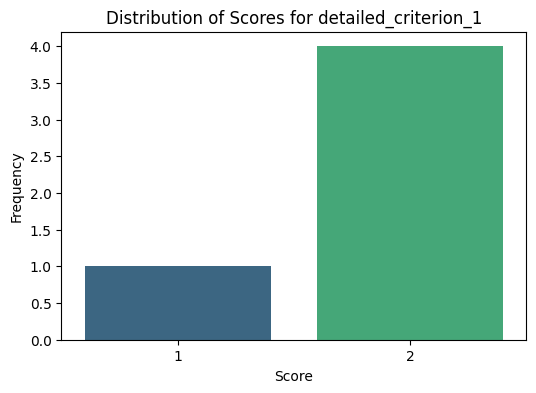

/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


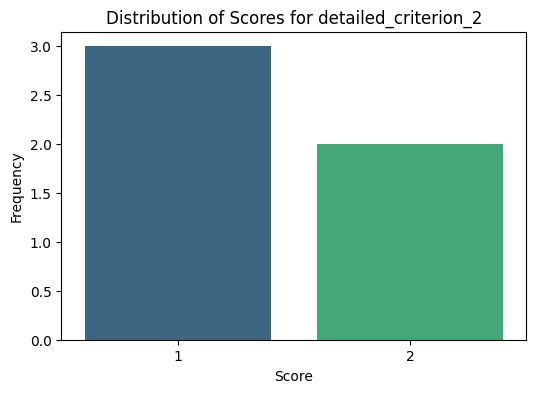

/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


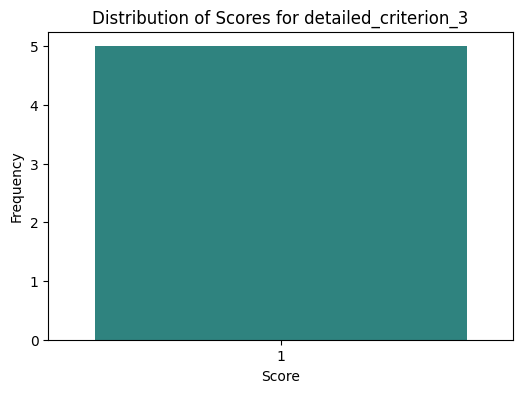

/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


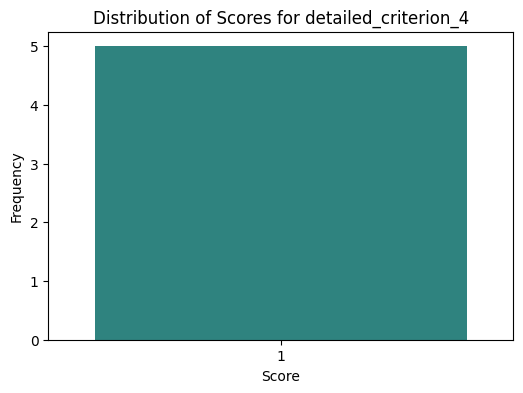

/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


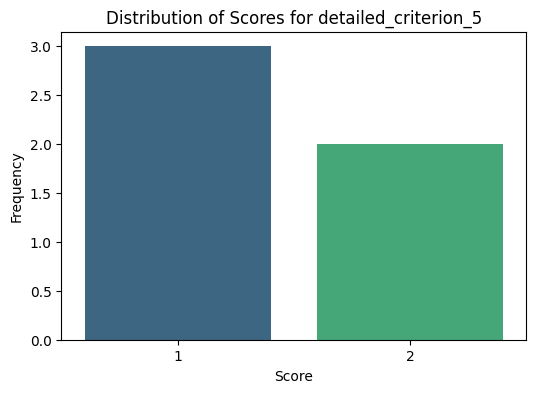

/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


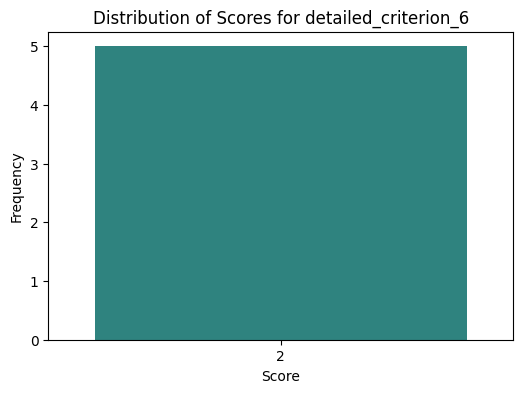

/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


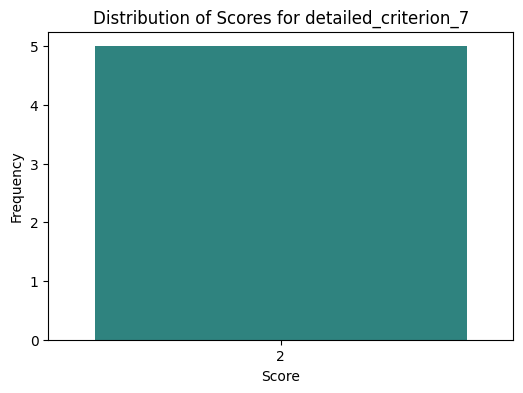

/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


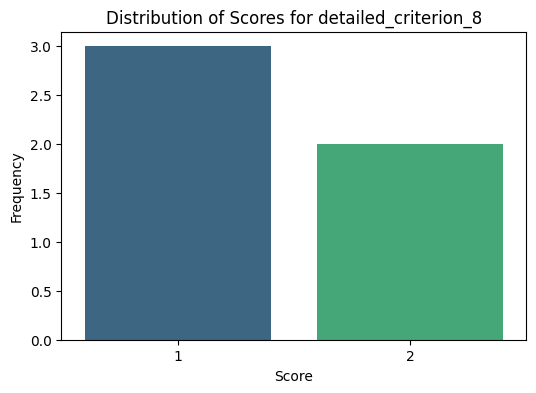

/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


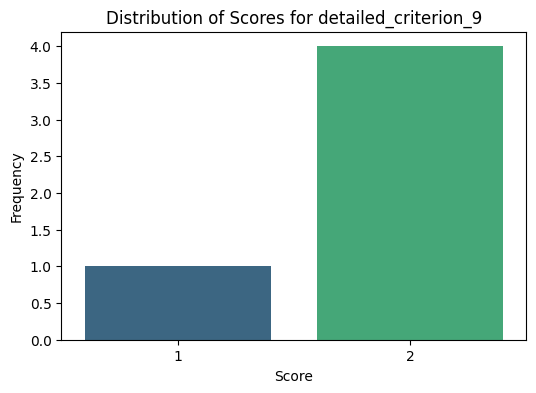

/tmp/ipython-input-3282770063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


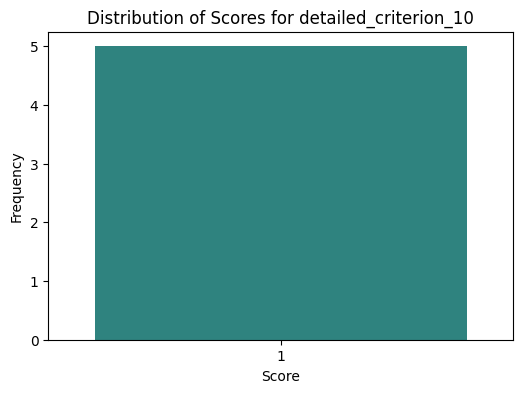

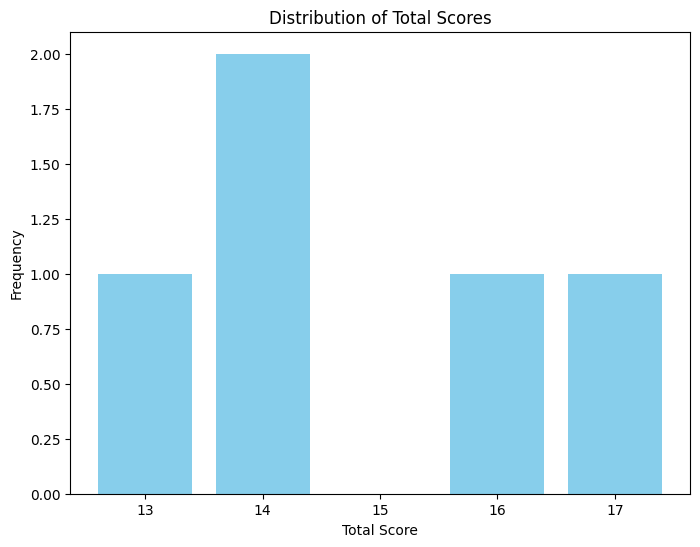

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

detailed_criterion_columns = [f'detailed_criterion_{i}' for i in range(1, 11)]

# Plot distribution for each detailed criterion
for col in detailed_criterion_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f"Distribution of Scores for {col}")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

# Plot histogram for the total detailed score
plt.figure(figsize=(8, 6))
plt.hist(df['detailed_total_score'], bins=range(df['detailed_total_score'].min(), df['detailed_total_score'].max() + 2), align='left', rwidth=0.8, color='skyblue')
plt.title("Distribution of Total Scores")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.xticks(range(df['detailed_total_score'].min(), df['detailed_total_score'].max() + 1))
plt.show()

## Save the updated dataframe

### Subtask:
Save the DataFrame with the new columns to a new CSV file.


**Reasoning**:
Save the DataFrame with the new detailed evaluation score columns to a new CSV file and print a confirmation message.



In [ ]:
df.to_csv("cases_evaluated.csv", index=False)
print("✅  Saved cases_evaluated.csv")

✅  Saved cases_evaluated.csv


## Summary:

### Data Analysis Key Findings

*   OpenAI successfully generated treatment recommendations for each patient case based on the provided case details and stored them in a new column `OpenAI_TG`.
*   Each OpenAI-generated guideline was compared against the existing OncoAI guideline using a 10-point rubric, and detailed scores for each criterion (0, 1, or 2) were stored in separate columns (`detailed_criterion_1` to `detailed_criterion_10`).
*   A total score, summing the scores from the 10 criteria, was calculated and stored in the `detailed_total_score` column.
*   Descriptive statistics (mean, median, std dev, etc.) and frequency distributions were calculated for both individual criterion scores and the total scores, providing a statistical overview of the evaluation results.
*   Visualizations (bar charts and histograms) were created to show the distribution of scores for each criterion and the overall distribution of the total scores.
*   The final DataFrame, including the generated OpenAI guidelines and the detailed evaluation scores, was successfully saved to a CSV file named 'cases\_evaluated.csv'.

### Insights or Next Steps

*   Analyze the distribution of scores to identify which specific criteria OpenAI recommendations align most closely with OncoAI guidelines and which areas show the most significant discrepancies.
*   Further investigate cases with low total scores to understand the specific reasons for the discrepancies and identify potential areas for improving the OpenAI prompt or model fine-tuning.
